In [1]:
import numpy as np
from matplotlib import pyplot as plt

from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from scipy.optimize import minimize

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

from ase.build import bulk


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [ ]:
KS_den = []
for i in np.arange(0,30,1):
    with open('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/0.5/si_0.5_'+str(i)+'_4_Btin_hd.out') as D:
        k = [match for match in D if "Kinetic energy" in match]
    KS_ke = str(k).split()[6]
    KS_KE.append(float(KS_ke)) 
ks_ke = np.asarray(KS_KE)

In [2]:
path_pp='/Users/valeria/Documents/PP/ofpp/EAC/upf/blps/'
file='si.lda.upf'
PP_list = {'Si': path_pp+file}

In [7]:
def min_delta_rho(x0, *args):
    rho_ks, ions = args
    rho_ks *= 16.0/rho_ks.integral()
    KE = Functional(type='KEDF',name='WT', rho0=x0)
    ions.set_charges(4)
    grid = DirectGrid(lattice=ions.cell, nr=[36,32,36])
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
    evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    optimization_options = {'econv' : 1e-5*ions.nat}
    opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                       optimization_method = 'TN')
    rho = opt.optimize_rho(guess_rho=rho_ini)
    rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    print(diff)
    return diff

In [8]:
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
l = np.linspace(0.8, 1.4, 30)
delta_rho = []
R0 = []
vol = []
for n in np.arange(0,30,1):
    i = int(n)
    rho_ks = io.read_density('/Users/valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/0.5/si_0.5_'+str(i)+'_4_Btin_hd.xsf')
    ions = Ions.from_ase(read('/Users/valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Transition_Btin_HD/0.5/si_0.5_'+str(i)+'_4_Btin_hd.in'))
    cell = ions.get_cell()
    ions.set_cell(cell * l[i], scale_atoms=True) 
    minn = minimize(min_delta_rho, 0.01, args = (rho_ks, ions), method='Powell', bounds=[[0,10]], options={'ftol' : 1e-6})
    vol.append(ions.get_volume())
    delta_rho.append(minn.fun)
    R0.append(minn.x)

setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -1.085592834328E+01     -1.085593E+01   8.971765E+00    1       1       6.504607E-02    
1       -1.252830626197E+01     -1.672378E+00   3.872730E+00    13      2       4.909420E-01    
2       -1.292117531448E+01     -3.928691E-01   2.373071E+00    15      1       1.045767E+00    
3       -1.310491137997E+01     -1.837361E-01   3.910957E+00    14      1       1.824726E+00    
4       -1.390454615420E+01     -7.996348E-01   2.382722E+00    16      4       2.351947E+00    
5       -1.400756237619E+01     -1.030162E-01   4.975623E-01    14      1       2.820056E+00    
6       -1.400976919428E+01     -2.206818E-03   1.706464E-01    15      1       3.498933E+00    
7       -1.401024336687E+01     -4.741726E-04   1.066758E-01    12      1       3.961156E+00    
8       -1.401051812622E+01     -2.747594E-04   9.0

ValueError: operands could not be broadcast together with shapes (36,32,36) (36,36,36) 

Text(0, 0.5, '$ρ_{0}$')

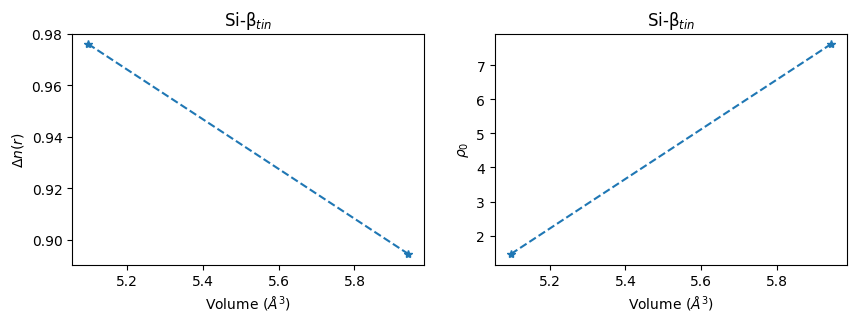

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(delta_rho)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(R0),'*--')
axs[0].set_title('Si-\u03B2$_{tin}$')
axs[1].set_title('Si-\u03B2$_{tin}$')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta n(r)$')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')